# Data Processing
**Data Cleaning, Missing Value Treatment, & Transformations**

In [123]:
import pandas as pd
import numpy as np
import datetime
import calendar
import timeit
import datetime as dt
import re
from math import exp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
start_time = datetime.datetime.now()

In [124]:
data = pd.read_csv('../Data/card transactions.csv')
data.shape

(96753, 18)

In [125]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,1,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5142183973,1/1/10,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5142131721,1/1/10,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,5142148452,1/1/10,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
data.dropna(how='all', axis=1, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96753 non-null  int64         
 1   Cardnum            96753 non-null  int64         
 2   Date               96753 non-null  datetime64[ns]
 3   Merchnum           93378 non-null  object        
 4   Merch description  96753 non-null  object        
 5   Merch state        95558 non-null  object        
 6   Merch zip          92097 non-null  float64       
 7   Transtype          96753 non-null  object        
 8   Amount             96753 non-null  float64       
 9   Fraud              96753 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.4+ MB


In [127]:
data = data[data['Transtype'] == 'P']
data = data[data['Amount'] <= 3000000]
data.shape

(96397, 10)

In [128]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3198
Merch description       0
Merch state          1020
Merch zip            4300
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [129]:
data_orig = data.copy()

## Clean and impute merchnum

In [130]:
data['Merchnum'] = data['Merchnum'].replace({'0':np.nan})

In [131]:
data['Merchnum'].isnull().sum()

3251

In [132]:
merchdes_merchnum = {}
for index, merchdes in data[data['Merch description'].notnull()][data['Merchnum'].notnull()]['Merch description'].items():
    if pd.isnull(merchdes) == True:
        continue
    elif merchdes not in merchdes_merchnum:
        merchdes_merchnum[merchdes] = data.loc[index, 'Merchnum']

In [133]:
# fill in by mapping with Merch description
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchdes_merchnum))

In [134]:
data['Merchnum'].isnull().sum()

2094

In [135]:
# assign unknown for adjustments transactions
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [136]:
data['Merchnum'].isnull().sum()

1403

In [137]:
data.loc[data.Merchnum.isna(), 'Merch description'].unique()[:20]

array(['MONTGOMERY COLLEGE-PHONE', 'PACKAGE PLACE  THE',
       'CUBIX CORPORATION', 'SIGNAL GRAPHICS PRINTING',
       'C & M OFFICE EQUIPMENT', "TOMMY'S TRAILERS",
       'Z WORLD/RABBIT SEMICONDUC', 'IMPAC/TRI-COUNTY/FREED',
       'REPROGRPHC TECHNLGIES INC', 'STP SPECIALITY TECH',
       'VANGARD INTERNAITONAL', 'BLACKWELL SCIENCE', 'CDN ISOTOPES INC',
       'INTERACTIVE SOFTWARE S', 'H R WILLIAMS MILL SUPP',
       'ELSEVIER SCIENCE BV', 'COLORADO GARDEN SHOW',
       'PEARSON EDUCATION CANADA', 'PONTOTOC AREA VO-TECH',
       'NATIONAL BAG COMPANY'], dtype=object)

In [138]:
# 1403 NULL Merchnums with 508 unique Descriptions
data.loc[data.Merchnum.isna(), 'Merch description'].nunique()

508

### Create new Merchnums using the description field

In [139]:
# adding new merchnums
# each new unique merchnum will be max(merchnum) + 1
merchnum_create = {}
max_merchnum = pd.to_numeric(data.Merchnum, errors='coerce').max()
for merch_desc in data.loc[data.Merchnum.isna(), 'Merch description'].unique():
  merchnum_create[merch_desc] = str(int(max_merchnum + 1))
  max_merchnum += 1

In [140]:
# fill in by mapping with Merch description (newly created merchnums)
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchnum_create))

In [141]:
for i in data.columns:
    print(i, data[i].isnull().sum())

Recnum 0
Cardnum 0
Date 0
Merchnum 0
Merch description 0
Merch state 1020
Merch zip 4300
Transtype 0
Amount 0
Fraud 0


## Clean and impute State

In [142]:
data['Merch state'].isnull().sum()

1020

In [143]:
data[(data['Merch state'].isnull()) & (data['Merch zip'].notnull())]['Merch zip'].unique()

array([9.2600e+02, 9.2900e+02, 1.4000e+03, 6.5132e+04, 8.6899e+04,
       2.3080e+04, 6.0528e+04, 9.3400e+02, 9.0200e+02, 7.3800e+02,
       9.0805e+04, 7.6302e+04, 9.0000e+00, 9.1400e+02, 6.0000e+00,
       9.5461e+04, 5.0823e+04, 2.0000e+00, 4.8700e+04, 6.8000e+02,
       1.0000e+00, 6.8100e+02, 6.2300e+02, 7.2600e+02, 9.3600e+02,
       1.2108e+04, 7.9100e+02, 9.0700e+02, 9.2200e+02, 9.2000e+02,
       3.0000e+00, 8.0100e+02, 8.0000e+00, 3.1040e+04, 3.8117e+04,
       4.1160e+04])

In [144]:
# dict for mapping
zip_state = {}
for index, zip5 in data[data['Merch zip'].notnull()]['Merch zip'].items():
    if zip5 not in zip_state:
        zip_state[zip5] = data.loc[index, 'Merch state']
        
zip_state['00926'] = 'PR'
zip_state['00929'] = 'PR'
zip_state['00934'] = 'PR'
zip_state['00902'] = 'PR'
zip_state['00738'] = 'PR'
zip_state['90805'] = 'CA'
zip_state['76302'] = 'TX'
zip_state['00914'] = 'PR'
zip_state['95461'] = 'CA'
zip_state['00680'] = 'PR'
zip_state['00623'] = 'PR'
zip_state['00726'] = 'PR'
zip_state['00936'] = 'PR'
zip_state['12108'] = 'NY'
zip_state['00791'] = 'PR'
zip_state['00907'] = 'PR'
zip_state['00922'] = 'PR'
zip_state['00920'] = 'PR'
zip_state['00801'] = 'VI'
zip_state['31040'] = 'GA'
zip_state['41160'] = 'KY'
zip_state['00681'] = 'PR'

In [146]:
merchnum_state = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_state :
        merchnum_state [merchnum] = data.loc[index, 'Merch state']

In [147]:
merchdes_state = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_state :
        merchdes_state [merchdes] = data.loc[index, 'Merch state']

In [148]:
# fill in by mapping with zip, merchnum and merch description
data['Merch state'] = data['Merch state'].fillna(data['Merch zip'].map(zip_state))
data['Merch state'] = data['Merch state'].fillna(data['Merchnum'].map(merchnum_state))
data['Merch state'] = data['Merch state'].fillna(data['Merch description'].map(merchdes_state))

In [149]:
# assign unknown for adjustments transactions
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [150]:
data['Merch state'].isnull().sum()

346

In [152]:
# change non-US states
# might actually be useful cus fraud could be foreign transactions
# maybe put a 'foreign' tag or just leave them as is

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", 
          'VI', 'PR', np.nan, 'unknown']

for index, state in data['Merch state'].items():
    if state not in states:
        data.loc[index, 'Merch state'] = 'foreign'

In [153]:
data['Merch state'].fillna('unknown',inplace=True)

In [154]:
data['Merch state'].isnull().sum()

0

## Clean and impute zip

In [155]:
data['Merch zip'].isnull().sum()

4300

In [156]:
merchnum_zip = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_zip :
        merchnum_zip [merchnum] = data.loc[index, 'Merch zip']

In [157]:
merchdes_zip = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_zip :
        merchdes_zip [merchdes] = data.loc[index, 'Merch zip']

In [158]:
# fill in by mapping with merchnum and merch description
data['Merch zip'] = data['Merch zip'].fillna(data['Merchnum'].map(merchnum_zip))
data['Merch zip'] = data['Merch zip'].fillna(data['Merch description'].map(merchdes_zip))

In [159]:
data['Merch zip'].isnull().sum()

2658

In [160]:
# assign unknown for adjustments transactions
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [161]:
data['Merch zip'].isnull().sum()

2658

In [162]:
temp = data[data['Merch zip'].isna()]
temp.head(50)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
51,52,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
54,55,5142146340,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,23.90,0
55,56,5142260984,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,19.95,0
58,59,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
59,60,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
60,61,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
61,62,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
62,63,5142253356,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,27.41,0
64,65,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
65,66,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0


In [163]:
data['Merch zip'].fillna('unknown', inplace=True)
data['Merch zip'].isnull().sum()

0

In [164]:
df = data.copy()

In [165]:
data.to_csv('transactions_clean.csv')

In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  int64         
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 10.1+ MB


## Target encoded variables

In [167]:
## to be safe, check the data type of dates first
df.Date = pd.to_datetime(df.Date)
df.Date.dtypes
## all good

dtype('<M8[ns]')

In [168]:
## find the day of the week
df['Dow'] = df.Date.apply(lambda x: calendar.day_name[x.weekday()])

In [169]:
## we want to not use the oot for target encoding variables
train_test = df[df.Date < '2010-11-01']
c = 4; nmid = 20; y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('Dow')['Fraud'].mean()
num = train_test.groupby('Dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
df['Dow_Risk'] = df.Dow.map(y_dow_smooth)

In [170]:
y_dow=y_dow.reset_index()
cats=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y_dow['Dow']=pd.Categorical(y_dow['Dow'], categories=cats, ordered=True)
y_dow=y_dow.sort_values('Dow')
y_dow=y_dow.set_index('Dow')
y_dow

,Fraud
Dow,
Monday,0.008711
Tuesday,0.007127
Wednesday,0.009788
Thursday,0.018626
Friday,0.025994
Saturday,0.010095
Sunday,0.009630


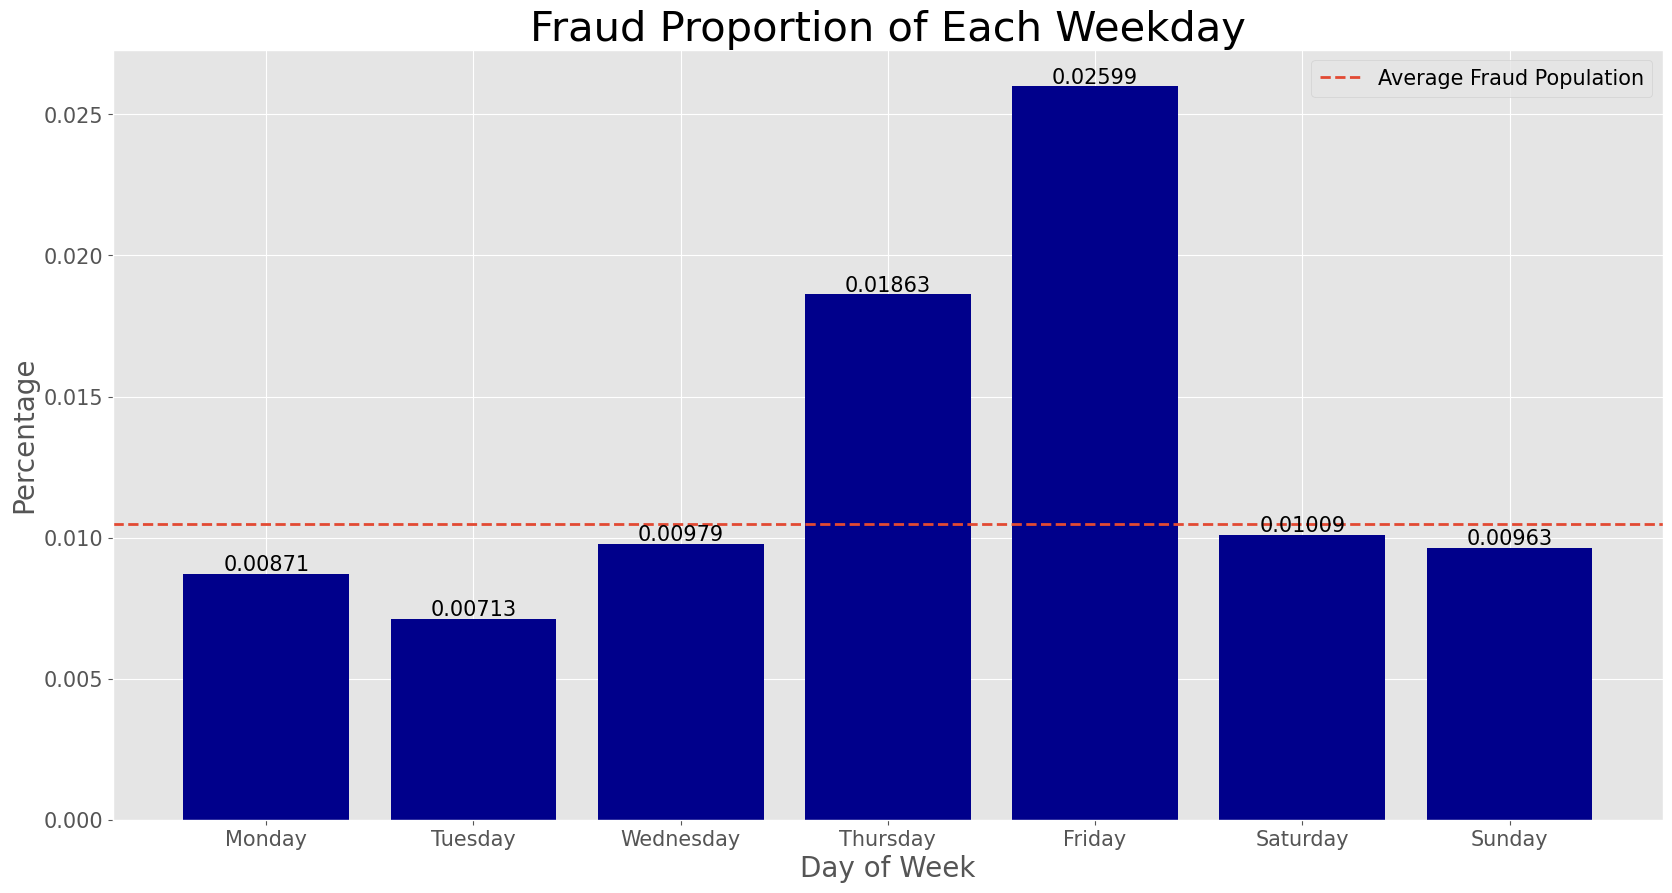

In [171]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data = y_dow, 
        x = y_dow.index, 
        height = 'Fraud',
        color = 'darkblue'
        )
#ax.set_ylim(bottom = 0.013)
ax.axhline(y = y_avg, ls = '--', lw = 2, label="Average Fraud Population")

for i, v in enumerate(y_dow.index):
    ax.text(v,y_dow.loc[v,'Fraud']+0.0001,round(y_dow.loc[v,'Fraud'],5),horizontalalignment='center',fontsize=15)

plt.legend(['Average Fraud Population'], fontsize=15)
plt.xlabel("Day of Week",fontsize=20)
plt.ylabel("Percentage",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Fraud Proportion of Each Weekday", fontsize=30)

plt.show()

In [172]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Dow,Dow_Risk
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Friday,0.025994
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Friday,0.025994
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994


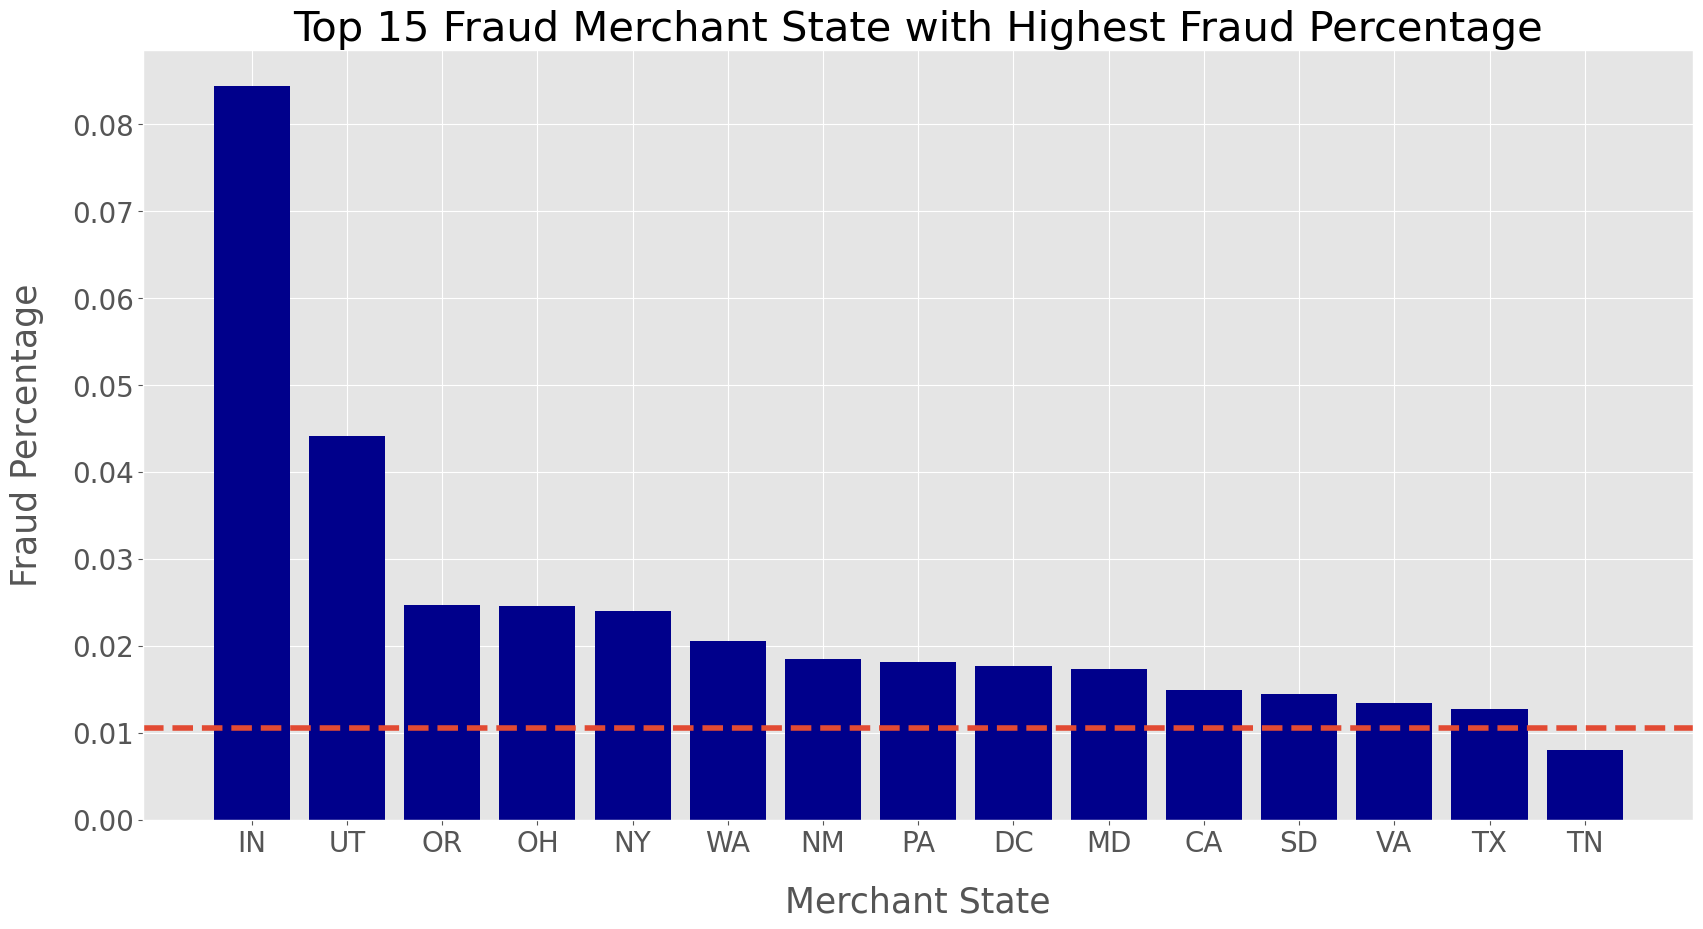

In [173]:
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_state = train_test.groupby('Merch state')['Fraud'].mean()
num = train_test.groupby('Merch state').size()
y_state_smooth = y_avg + (y_state - y_avg)/(1 + np.exp(-(num-nmid)/c))
df['state_risk'] = df['Merch state'].map(y_state_smooth)
top15_states = pd.DataFrame(y_state.sort_values(ascending=False).head(15))
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data=top15_states, x=top15_states.index, height='Fraud', color='darkblue')

plt.title('Top 15 Fraud Merchant State with Highest Fraud Percentage', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Merchant State',fontsize=25, labelpad=20)
plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)

ax.axhline(y=y_avg, lw = 4, ls='--')
plt.show()

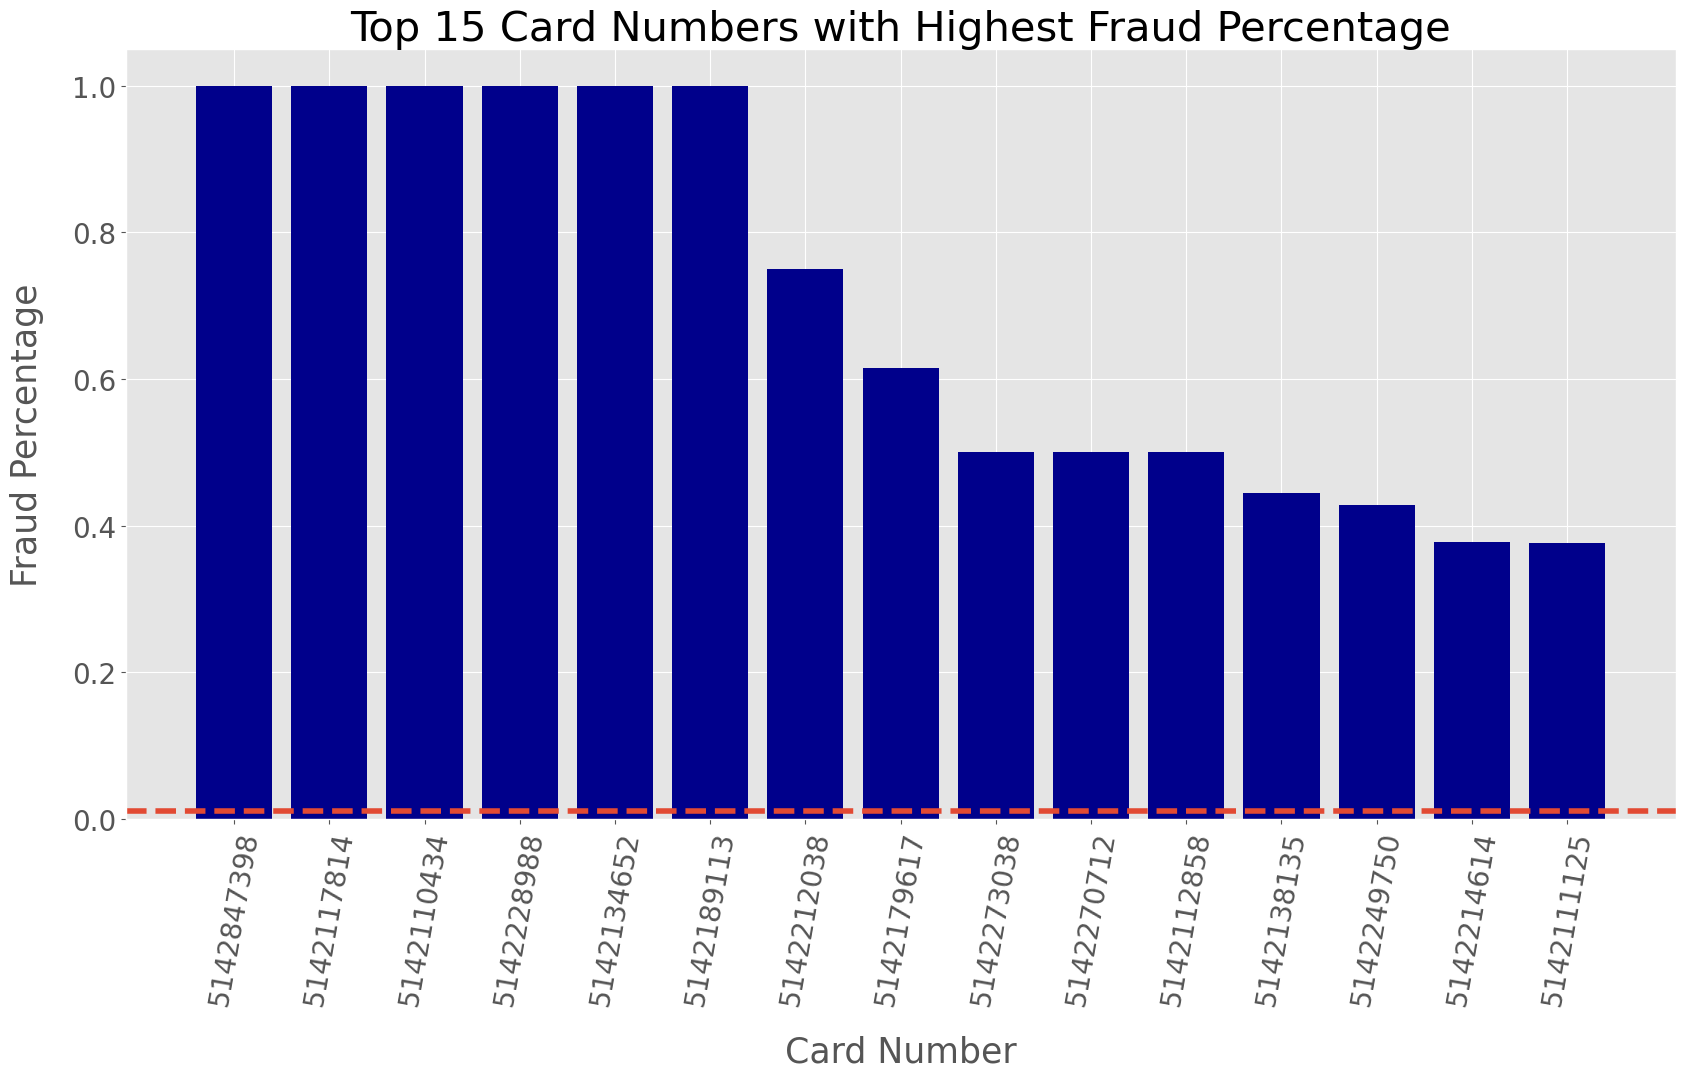

In [174]:
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_cardnum = train_test.groupby('Cardnum')['Fraud'].mean()
num = train_test.groupby('Cardnum').size()
y_cardnum_smooth = y_avg + (y_cardnum - y_avg)/(1 + np.exp(-(num-nmid)/c))

# comment this out so we don't include this variable because it overfits
# df['cardnum_risk'] = df['Cardnum'].map(y_cardnum_smooth)
top15_cardnum = pd.DataFrame(y_cardnum\
                             .sort_values(ascending=False).head(15))
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data=top15_cardnum, x=top15_cardnum.index.astype(str), height='Fraud', color='darkblue')
plt.title('Top 15 Card Numbers with Highest Fraud Percentage', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Card Number',fontsize=25, labelpad=20)
plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)
plt.xticks(rotation = 80)

ax.axhline(y=y_avg, lw = 4, ls='--')

plt.show()

In [175]:
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_merchnum = train_test.groupby('Merchnum')['Fraud'].mean()
num = train_test.groupby('Merchnum').size()
y_merchnum_smooth = y_avg + (y_merchnum - y_avg)/(1 + np.exp(-(num-nmid)/c))

# comment this out so we don't include this variable because it overfits
# data['merchnum_risk'] = data['Merchnum'].map(y_merchnum_smooth)
top15_merchnum = pd.DataFrame(y_merchnum\
                             .sort_values(ascending=False).head(15))
top15_merchnum.head(20)

# plt.style.use('ggplot')
# fig, ax = plt.subplots(figsize=(20,10))
# plt.bar(data=top15_merchnum, x=top15_merchnum.index.astype(str), height='Fraud', color='darkblue')
# plt.title('Top 15 Merchant Numbers with Highest Fraud Percentage', fontsize=30)

# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.xlabel('Merchant Number',fontsize=25, labelpad=20)
# plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)
# plt.xticks(rotation = 80)

# ax.axhline(y=y_avg, lw = 4, ls='--')

# plt.show()

,Fraud
Merchnum,
450730006NOT0,1.000000
6006333528866,1.000000
4503738417400,1.000000
600660007477,1.000000
19908503337,1.000000
7000330100777,1.000000
8834000695423,1.000000
7593860080752,1.000000
92891948003,1.000000


In [176]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Dow,Dow_Risk,state_risk
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,0.007970
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Friday,0.025994,0.003304
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Friday,0.025994,0.017282
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,0.007970
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,0.007970


## Other variables

### 2.1. Data types

In [177]:
df['Cardnum'] = df['Cardnum'].apply(str)
df['Merchnum'] = df['Merchnum'].apply(str)
df['Merch zip'] = df['Merch zip'].apply(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  object        
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
 10  Dow                96397 non-null  object        
 11  Dow_Risk           96397 non-null  float64       
 12  state_risk         96397 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory 

In [178]:
### add leading 0 to zips
### note: there are some zips that are state abbrv. as we imputed them ealier, so pandas read the column as str

def leading_0(x):
    
    if '.0' in x:
        x = x[:-2]
        if len(x) == 5:
            return x
        else: 
            return '0'*(5-len(x)) + x
    else:
        return '0'*(5-len(x)) + x

# df['Merch zip'] = df['Merch zip'].apply(leading_0)

In [179]:
### delete white spaces in merch description
df['Merch description'] = df['Merch description'].str.replace(r'\s', '')

### Create entities

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  object        
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
 10  Dow                96397 non-null  object        
 11  Dow_Risk           96397 non-null  float64       
 12  state_risk         96397 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory 

In [181]:
df['card_merch'] = df['Cardnum'] + df['Merchnum']
df['card_zip'] = df['Cardnum'] + df['Merch zip']
df['card_state'] = df['Cardnum'] + df['Merch state']
df['merch_zip'] = df['Merchnum'] + df['Merch zip']
df['merch_state'] = df['Merchnum'] + df['Merch state']
df['state_des'] = df['Merch state'] + df['Merch description']

# these next entity take a long time to calculate the variables for, and I don't know why
# df['state_zip'] = df['Merch state'] + df['Merch zip']

df['zip3'] = df['Merch zip'].str[:3]
df['card_zip3'] = df.Cardnum + df['zip3']
# df['merchnum_zip'] = df.Merchnum + df['Merch zip']
# df['merchnum_zip3'] = df.Merchnum + df['zip3']
df['Card_Merchdesc'] = df['Cardnum'] + df['Merch description']
df['Card_dow'] = df['Cardnum'] + df['Dow']
df['Merchnum_desc'] = df['Merchnum'] + df['Merch description']
df['Merchnum_dow'] = df['Merchnum'] + df['Dow']
# df['Merchdesc_State'] = df['Merch description'] + df['Merch state']
# df['Merchdesc_Zip'] = df['Merch description'] + df['Merch zip']
df['Merchdesc_dow'] = df['Merch description'] + df['Dow']
df['Card_Merchnum_desc'] = df['Cardnum'] + df['Merchnum'] + df['Merch description']
# df['Card_Merchnum_State'] = df['Cardnum'] + df['Merchnum'] + df['Merch state']
df['Card_Merchnum_Zip'] = df['Cardnum'] + df['Merchnum'] + df['Merch zip']
# df['Card_Merchdesc_State'] = df['Cardnum'] + df['Merch description'] + df['Merch state']
df['Card_Merchdesc_Zip'] = df['Cardnum'] + df['Merch description'] + df['Merch zip']
df['Merchnum_desc_State'] = df['Merchnum'] + df['Merch description'] + df['Merch state']
# df['Merchnum_desc_Zip'] = df['Merchnum'] + df['Merch description'] + df['Merch zip']


In [182]:
df.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       'Dow_Risk', 'state_risk', 'card_merch', 'card_zip', 'card_state',
       'merch_zip', 'merch_state', 'state_des', 'zip3', 'card_zip3',
       'Card_Merchdesc', 'Card_dow', 'Merchnum_desc', 'Merchnum_dow',
       'Merchdesc_dow', 'Card_Merchnum_desc', 'Card_Merchnum_Zip',
       'Card_Merchdesc_Zip', 'Merchnum_desc_State'],
      dtype='object')

In [183]:
entities = list(df.iloc[:, np.r_[1, 3, 12:len(df.columns)]].columns)

In [184]:
entities

['Cardnum',
 'Merchnum',
 'state_risk',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'zip3',
 'card_zip3',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State']

In [185]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,card_zip3,Card_Merchdesc,Card_dow,Merchnum_desc,Merchnum_dow,Merchdesc_dow,Card_Merchnum_desc,Card_Merchnum_Zip,Card_Merchdesc_Zip,Merchnum_desc_State
0,1,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118.0,P,3.62,0,...,5142190439381,5142190439FEDEXSHP12/23/09AB#,5142190439Friday,5509006296254FEDEXSHP12/23/09AB#,5509006296254Friday,FEDEXSHP12/23/09AB#Friday,51421904395509006296254FEDEXSHP12/23/09AB#,5142190439550900629625438118.0,5142190439FEDEXSHP12/23/09AB#38118.0,5509006296254FEDEXSHP12/23/09AB#TN
1,2,5142183973,2010-01-01,61003026333,SERVICEMERCHANDISE#81,MA,1803.0,P,31.42,0,...,5142183973180,5142183973SERVICEMERCHANDISE#81,5142183973Friday,61003026333SERVICEMERCHANDISE#81,61003026333Friday,SERVICEMERCHANDISE#81Friday,514218397361003026333SERVICEMERCHANDISE#81,5142183973610030263331803.0,5142183973SERVICEMERCHANDISE#811803.0,61003026333SERVICEMERCHANDISE#81MA
2,3,5142131721,2010-01-01,4503082993600,OFFICEDEPOT#191,MD,20706.0,P,178.49,0,...,5142131721207,5142131721OFFICEDEPOT#191,5142131721Friday,4503082993600OFFICEDEPOT#191,4503082993600Friday,OFFICEDEPOT#191Friday,51421317214503082993600OFFICEDEPOT#191,5142131721450308299360020706.0,5142131721OFFICEDEPOT#19120706.0,4503082993600OFFICEDEPOT#191MD
3,4,5142148452,2010-01-01,5509006296254,FEDEXSHP12/28/09AB#,TN,38118.0,P,3.62,0,...,5142148452381,5142148452FEDEXSHP12/28/09AB#,5142148452Friday,5509006296254FEDEXSHP12/28/09AB#,5509006296254Friday,FEDEXSHP12/28/09AB#Friday,51421484525509006296254FEDEXSHP12/28/09AB#,5142148452550900629625438118.0,5142148452FEDEXSHP12/28/09AB#38118.0,5509006296254FEDEXSHP12/28/09AB#TN
4,5,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118.0,P,3.62,0,...,5142190439381,5142190439FEDEXSHP12/23/09AB#,5142190439Friday,5509006296254FEDEXSHP12/23/09AB#,5509006296254Friday,FEDEXSHP12/23/09AB#Friday,51421904395509006296254FEDEXSHP12/23/09AB#,5142190439550900629625438118.0,5142190439FEDEXSHP12/23/09AB#38118.0,5509006296254FEDEXSHP12/23/09AB#TN


### Variables

In [186]:
df.Date = pd.to_datetime(df.Date)
df1 = df.copy()
final = df.copy()
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum

## Make the Benford's law top 40 tables and variables

In [188]:
# another way to get the first digit
bf = data.copy()
bf['amount_100'] = (bf['Amount'] * 100).astype(str)
bf['first_digit'] = bf['amount_100'].str[0]
bf['first_digit'].value_counts()

1    26603
3    18670
2    16178
4     8278
5     6955
6     6017
7     5027
8     4534
9     4135
Name: first_digit, dtype: int64

In [189]:
dropfedex = bf[bf['Merch description'].str.contains('FEDEX')]
dropfedex.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_100,first_digit
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,362.0,3
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,362.0,3
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,362.0,3
5,6,5142149874,2010-01-01,5509006296254,FEDEX SHP 12/22/09 AB#,TN,38118.0,P,3.67,0,367.0,3
6,7,5142189277,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,362.0,3


In [190]:
droplist = dropfedex.index.tolist()
droplist[:10]

[0, 3, 4, 5, 6, 9, 10, 11, 12, 15]

In [191]:
droplist[-10:]

[96246, 96291, 96292, 96319, 96397, 96415, 96426, 96433, 96459, 96727]

In [192]:
len(droplist)

11775

In [193]:
bf.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_100,first_digit
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,362.0,3
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,3142.0,3
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,17849.0,1
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,362.0,3
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,362.0,3


In [194]:
bf.shape

(96397, 12)

In [195]:
bf1 = bf.drop(droplist)
bf1.shape

(84622, 12)

In [196]:
# datefilter = datetime.datetime(2010,11,1)
# bf1 = bf1[bf1['Date'] < datefilter]
# bf1.shape

In [197]:
bf1['bin']= bf1['first_digit'].apply(lambda x: "low" if x == "1" else ("low" if x == "2" else "high"))
bf1.head(5)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_100,first_digit,bin
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,3142.0,3,high
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,17849.0,1,low
7,8,5142191182,2010-01-01,6098208200062,MIAMI COMPUTER SUPPLY,OH,45429.0,P,230.32,0,23032.0,2,low
8,9,5142258629,2010-01-01,602608969534,FISHER SCI ATL,GA,30091.0,P,62.11,0,6211.0,6,high
13,14,5142124791,2010-01-01,5725000466504,CDW*GOVERNMENT INC,IL,60061.0,P,106.89,0,10689.0,1,low


In [198]:
bf1['first_digit'].value_counts()

1    25697
2    15827
3    10297
4     7686
5     6749
6     5469
7     4699
8     4152
9     4046
Name: first_digit, dtype: int64

In [199]:
# calculating n_low and n_high
card_bf =  bf1.groupby(['Cardnum','bin']).agg({'bin': ['count']}).reset_index()
card_bf.columns=['Cardnum', 'bin', 'count']
card_bf

,Cardnum,bin,count
0,5142110002,low,1
1,5142110081,high,4
2,5142110313,high,1
3,5142110313,low,2
4,5142110402,high,8
...,...,...,...
3128,5142310598,low,2
3129,5142310768,high,2
3130,5142310768,low,2
3131,5142847398,high,35


In [200]:
card_bf =  card_bf.pivot_table(index='Cardnum',columns='bin',values='count',aggfunc='sum').reset_index()
card_bf.columns=['Cardnum', 'n_high', 'n_low']
card_bf

,Cardnum,n_high,n_low
0,5142110002,NaN,1.0
1,5142110081,4.0,NaN
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,NaN,1.0
...,...,...,...
1635,5142310397,1.0,NaN
1636,5142310525,3.0,1.0
1637,5142310598,NaN,2.0
1638,5142310768,2.0,2.0


In [201]:
# if either n_low or n_high is zero, set it to 1
card_bf = card_bf.fillna(1)
card_bf

,Cardnum,n_high,n_low
0,5142110002,1.0,1.0
1,5142110081,4.0,1.0
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,1.0,1.0
...,...,...,...
1635,5142310397,1.0,1.0
1636,5142310525,3.0,1.0
1637,5142310598,1.0,2.0
1638,5142310768,2.0,2.0


In [202]:
# calclating R, 1/R, U, n, t U_smoothed
c=3
n_mid=15
card_bf['R'] = (1.096 * card_bf['n_low']/card_bf['n_high'])
card_bf['1/R'] = (1/card_bf['R'])
card_bf['U'] = list(map(lambda x, y : max(x,y),card_bf['R'],card_bf['1/R']))
card_bf['n'] = card_bf['n_high'] + card_bf['n_low']
card_bf['t'] = ((card_bf['n']-n_mid)/c)
card_bf['U_smoothed']= list(map(lambda x, y : (1 + (x-1)/(1+exp(-y))),card_bf['U'],card_bf['t']))

In [203]:
top40_card_bf = card_bf.sort_values(['U_smoothed'], ascending = False).head(40).reset_index(drop = True)
top40_card_bf.head(40)

,Cardnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,5142253356,5.0,61.0,13.371200,0.074788,13.371200,66.0,17.000000,13.371199
1,5142299705,3.0,25.0,9.133333,0.109489,9.133333,28.0,4.333333,9.027976
2,5142197563,134.0,15.0,0.122687,8.150852,8.150852,149.0,44.666667,8.150852
3,5142194617,33.0,5.0,0.166061,6.021898,6.021898,38.0,7.666667,6.019548
4,5142288241,13.0,1.0,0.084308,11.861314,11.861314,14.0,-0.333333,5.533836
5,5142239140,3.0,16.0,5.845333,0.171077,5.845333,19.0,1.333333,4.834555
6,5142144931,30.0,6.0,0.219200,4.562044,4.562044,36.0,7.000000,4.558799
7,5142192606,2.0,13.0,7.124000,0.140371,7.124000,15.0,0.000000,4.062000
8,5142204384,54.0,199.0,4.038963,0.247588,4.038963,253.0,79.333333,4.038963
9,5142284940,6.0,21.0,3.836000,0.260688,3.836000,27.0,4.000000,3.784991


In [204]:
# calculating n_low and n_high
merch_bf =  bf1.groupby(['Merchnum','bin']).agg({'bin': ['count']}).reset_index()
merch_bf.columns=['Merchnum', 'bin', 'count']
merch_bf =  merch_bf.pivot_table(index='Merchnum',columns='bin',values='count',aggfunc='sum').reset_index()
merch_bf.columns=['Merchnum', 'n_high', 'n_low']
merch_bf.head()

,Merchnum,n_high,n_low
0,003100006NOT6,1.0,NaN
1,004740006ABC6,NaN,1.0
2,005590006PNB6,1.0,NaN
3,014430619 14,NaN,1.0
4,014938913 51,1.0,NaN


In [205]:
# if either n_low or n_high is zero, set it to 1
merch_bf = merch_bf.fillna(1)
merch_bf

,Merchnum,n_high,n_low
0,003100006NOT6,1.0,1.0
1,004740006ABC6,1.0,1.0
2,005590006PNB6,1.0,1.0
3,014430619 14,1.0,1.0
4,014938913 51,1.0,1.0
...,...,...,...
13586,DU49038320006,1.0,1.0
13587,JCPENNE9 CO,2.0,1.0
13588,PENNE9 CO #05,1.0,1.0
13589,PENNE9 CO #68,1.0,1.0


In [206]:
# calclating R, 1/R, U, n, t U_smoothed
merch_bf['R'] = (1.096 * merch_bf['n_low']/merch_bf['n_high'])
merch_bf['1/R'] = (1/merch_bf['R'])
merch_bf['U'] = list(map(lambda x, y : max(x,y),merch_bf['R'],merch_bf['1/R']))
merch_bf['n'] = merch_bf['n_high'] + merch_bf['n_low']
merch_bf['t'] = ((merch_bf['n']-n_mid)/c)
merch_bf['U_smoothed']= list(map(lambda x, y : (1 + (x-1)/(1+exp(-y))),merch_bf['U'],merch_bf['t']))

In [207]:
top40_merch_bf = merch_bf.sort_values(['U_smoothed'], ascending = False).head(40).reset_index(drop = True)
top40_merch_bf.head(40)

,Merchnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,991808369338,181.0,1.0,0.006055,165.145985,165.145985,182.0,55.666667,165.145985
1,8078200641472,1.0,59.0,64.664000,0.015465,64.664000,60.0,15.000000,64.663981
2,308904389335,53.0,1.0,0.020679,48.357664,48.357664,54.0,13.000000,48.357557
3,3523000628102,1.0,34.0,37.264000,0.026836,37.264000,35.0,6.666667,37.217908
4,808998385332,36.0,1.0,0.030444,32.846715,32.846715,37.0,7.333333,32.825921
5,55158027,1.0,27.0,29.592000,0.033793,29.592000,28.0,4.333333,29.221627
6,8916500620062,31.0,1.0,0.035355,28.284672,28.284672,32.0,5.666667,28.190609
7,3910694900001,1.0,25.0,27.400000,0.036496,27.400000,26.0,3.666667,26.741995
8,881145544,1.0,24.0,26.304000,0.038017,26.304000,25.0,3.333333,25.432399
9,8889817332,1.0,24.0,26.304000,0.038017,26.304000,25.0,3.333333,25.432399


In [208]:
# Here are the tables for the Benford's law. They would be useful for a forensic analysis
top40_card_bf.to_csv('Benford top cards.csv')
top40_merch_bf.to_csv('Benford top merchs.csv')

In [209]:
card_bf['Cardnum'] = card_bf['Cardnum'].apply(str)
merch_bf['Merchnum'] = merch_bf['Merchnum'].apply(str)
card_bf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Cardnum     1640 non-null   object 
 1   n_high      1640 non-null   float64
 2   n_low       1640 non-null   float64
 3   R           1640 non-null   float64
 4   1/R         1640 non-null   float64
 5   U           1640 non-null   float64
 6   n           1640 non-null   float64
 7   t           1640 non-null   float64
 8   U_smoothed  1640 non-null   float64
dtypes: float64(8), object(1)
memory usage: 115.4+ KB


In [210]:
card_bf.set_index('Cardnum',inplace=True)

In [211]:
card_Ustar = pd.DataFrame(card_bf['U_smoothed'])
card_Ustar.sort_values(['U_smoothed'], ascending = False).head(10)

,U_smoothed
Cardnum,
5142253356,13.371199
5142299705,9.027976
5142197563,8.150852
5142194617,6.019548
5142288241,5.533836
5142239140,4.834555
5142144931,4.558799
5142192606,4.062000
5142204384,4.038963


In [212]:
merch_bf.set_index('Merchnum',inplace=True)

In [213]:
merch_Ustar = pd.DataFrame(merch_bf['U_smoothed'])
merch_Ustar.sort_values(['U_smoothed'], ascending = False).head(10)

,U_smoothed
Merchnum,
991808369338,165.145985
8078200641472,64.663981
308904389335,48.357557
3523000628102,37.217908
808998385332,32.825921
55158027,29.221627
8916500620062,28.190609
3910694900001,26.741995
881145544,25.432399


In [214]:
final = final.merge(card_Ustar, how = 'left',left_on='Cardnum',right_on=card_Ustar.index)
final = final.rename(columns={'U_smoothed':'U*_cardnum'})
final = final.merge(merch_Ustar, how = 'left',left_on='Merchnum',right_on=merch_Ustar.index)
final = final.rename(columns={'U_smoothed':'U*_merchnum'})

In [215]:
final

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Card_dow,Merchnum_desc,Merchnum_dow,Merchdesc_dow,Card_Merchnum_desc,Card_Merchnum_Zip,Card_Merchdesc_Zip,Merchnum_desc_State,U*_cardnum,U*_merchnum
0,1,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118.0,P,3.62,0,...,5142190439Friday,5509006296254FEDEXSHP12/23/09AB#,5509006296254Friday,FEDEXSHP12/23/09AB#Friday,51421904395509006296254FEDEXSHP12/23/09AB#,5142190439550900629625438118.0,5142190439FEDEXSHP12/23/09AB#38118.0,5509006296254FEDEXSHP12/23/09AB#TN,2.178008,NaN
1,2,5142183973,2010-01-01,61003026333,SERVICEMERCHANDISE#81,MA,1803.0,P,31.42,0,...,5142183973Friday,61003026333SERVICEMERCHANDISE#81,61003026333Friday,SERVICEMERCHANDISE#81Friday,514218397361003026333SERVICEMERCHANDISE#81,5142183973610030263331803.0,5142183973SERVICEMERCHANDISE#811803.0,61003026333SERVICEMERCHANDISE#81MA,1.604857,1.001244
2,3,5142131721,2010-01-01,4503082993600,OFFICEDEPOT#191,MD,20706.0,P,178.49,0,...,5142131721Friday,4503082993600OFFICEDEPOT#191,4503082993600Friday,OFFICEDEPOT#191Friday,51421317214503082993600OFFICEDEPOT#191,5142131721450308299360020706.0,5142131721OFFICEDEPOT#19120706.0,4503082993600OFFICEDEPOT#191MD,2.368143,1.025818
3,4,5142148452,2010-01-01,5509006296254,FEDEXSHP12/28/09AB#,TN,38118.0,P,3.62,0,...,5142148452Friday,5509006296254FEDEXSHP12/28/09AB#,5509006296254Friday,FEDEXSHP12/28/09AB#Friday,51421484525509006296254FEDEXSHP12/28/09AB#,5142148452550900629625438118.0,5142148452FEDEXSHP12/28/09AB#38118.0,5509006296254FEDEXSHP12/28/09AB#TN,1.044105,NaN
4,5,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118.0,P,3.62,0,...,5142190439Friday,5509006296254FEDEXSHP12/23/09AB#,5509006296254Friday,FEDEXSHP12/23/09AB#Friday,51421904395509006296254FEDEXSHP12/23/09AB#,5142190439550900629625438118.0,5142190439FEDEXSHP12/23/09AB#38118.0,5509006296254FEDEXSHP12/23/09AB#TN,2.178008,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,BESTBUY00001610,KY,41042.0,P,84.79,0,...,5142276053Friday,3500000006160BESTBUY00001610,3500000006160Friday,BESTBUY00001610Friday,51422760533500000006160BESTBUY00001610,5142276053350000000616041042.0,5142276053BESTBUY0000161041042.0,3500000006160BESTBUY00001610KY,1.002393,1.001244
96393,96750,5142225701,2010-12-31,8090710030950,MARKUSOFFICESUPPLIES,OH,45248.0,P,118.75,0,...,5142225701Friday,8090710030950MARKUSOFFICESUPPLIES,8090710030950Friday,MARKUSOFFICESUPPLIESFriday,51422257018090710030950MARKUSOFFICESUPPLIES,5142225701809071003095045248.0,5142225701MARKUSOFFICESUPPLIES45248.0,8090710030950MARKUSOFFICESUPPLIESOH,1.137948,1.288057
96394,96751,5142226486,2010-12-31,4503057341100,"TECHPAC,INC",OH,45150.0,P,363.56,0,...,5142226486Friday,"4503057341100TECHPAC,INC",4503057341100Friday,"TECHPAC,INCFriday","51422264864503057341100TECHPAC,INC",5142226486450305734110045150.0,"5142226486TECHPAC,INC45150.0","4503057341100TECHPAC,INCOH",1.201338,1.106055
96395,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0,...,5142244619Friday,8834000695412BUY.COM,8834000695412Friday,BUY.COMFriday,51422446198834000695412BUY.COM,5142244619883400069541292656.0,5142244619BUY.COM92656.0,8834000695412BUY.COMCA,1.499767,1.029441


In [91]:
final['U*_cardnum'].isna().sum()

72

In [92]:
final['U*_merchnum'].isna().sum()

11775

In [93]:
final['U*_cardnum'].fillna(1,inplace=True)
final['U*_merchnum'].fillna(1,inplace=True)

In [94]:
final['U*_cardnum'].isna().sum()

0

In [95]:
final['U*_merchnum'].isna().sum()

0

In [96]:
print(final.shape)
final.drop(columns=['U*_cardnum','U*_merchnum'],inplace=True)
print(final.shape)

(96397, 32)
(96397, 30)


In [97]:
final

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,card_zip3,Card_Merchdesc,Card_dow,Merchnum_desc,Merchnum_dow,Merchdesc_dow,Card_Merchnum_desc,Card_Merchnum_Zip,Card_Merchdesc_Zip,Merchnum_desc_State
0,1,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118.0,P,3.62,0,...,5142190439381,5142190439FEDEXSHP12/23/09AB#,5142190439Friday,5509006296254FEDEXSHP12/23/09AB#,5509006296254Friday,FEDEXSHP12/23/09AB#Friday,51421904395509006296254FEDEXSHP12/23/09AB#,5142190439550900629625438118.0,5142190439FEDEXSHP12/23/09AB#38118.0,5509006296254FEDEXSHP12/23/09AB#TN
1,2,5142183973,2010-01-01,61003026333,SERVICEMERCHANDISE#81,MA,1803.0,P,31.42,0,...,5142183973180,5142183973SERVICEMERCHANDISE#81,5142183973Friday,61003026333SERVICEMERCHANDISE#81,61003026333Friday,SERVICEMERCHANDISE#81Friday,514218397361003026333SERVICEMERCHANDISE#81,5142183973610030263331803.0,5142183973SERVICEMERCHANDISE#811803.0,61003026333SERVICEMERCHANDISE#81MA
2,3,5142131721,2010-01-01,4503082993600,OFFICEDEPOT#191,MD,20706.0,P,178.49,0,...,5142131721207,5142131721OFFICEDEPOT#191,5142131721Friday,4503082993600OFFICEDEPOT#191,4503082993600Friday,OFFICEDEPOT#191Friday,51421317214503082993600OFFICEDEPOT#191,5142131721450308299360020706.0,5142131721OFFICEDEPOT#19120706.0,4503082993600OFFICEDEPOT#191MD
3,4,5142148452,2010-01-01,5509006296254,FEDEXSHP12/28/09AB#,TN,38118.0,P,3.62,0,...,5142148452381,5142148452FEDEXSHP12/28/09AB#,5142148452Friday,5509006296254FEDEXSHP12/28/09AB#,5509006296254Friday,FEDEXSHP12/28/09AB#Friday,51421484525509006296254FEDEXSHP12/28/09AB#,5142148452550900629625438118.0,5142148452FEDEXSHP12/28/09AB#38118.0,5509006296254FEDEXSHP12/28/09AB#TN
4,5,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118.0,P,3.62,0,...,5142190439381,5142190439FEDEXSHP12/23/09AB#,5142190439Friday,5509006296254FEDEXSHP12/23/09AB#,5509006296254Friday,FEDEXSHP12/23/09AB#Friday,51421904395509006296254FEDEXSHP12/23/09AB#,5142190439550900629625438118.0,5142190439FEDEXSHP12/23/09AB#38118.0,5509006296254FEDEXSHP12/23/09AB#TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,BESTBUY00001610,KY,41042.0,P,84.79,0,...,5142276053410,5142276053BESTBUY00001610,5142276053Friday,3500000006160BESTBUY00001610,3500000006160Friday,BESTBUY00001610Friday,51422760533500000006160BESTBUY00001610,5142276053350000000616041042.0,5142276053BESTBUY0000161041042.0,3500000006160BESTBUY00001610KY
96393,96750,5142225701,2010-12-31,8090710030950,MARKUSOFFICESUPPLIES,OH,45248.0,P,118.75,0,...,5142225701452,5142225701MARKUSOFFICESUPPLIES,5142225701Friday,8090710030950MARKUSOFFICESUPPLIES,8090710030950Friday,MARKUSOFFICESUPPLIESFriday,51422257018090710030950MARKUSOFFICESUPPLIES,5142225701809071003095045248.0,5142225701MARKUSOFFICESUPPLIES45248.0,8090710030950MARKUSOFFICESUPPLIESOH
96394,96751,5142226486,2010-12-31,4503057341100,"TECHPAC,INC",OH,45150.0,P,363.56,0,...,5142226486451,"5142226486TECHPAC,INC",5142226486Friday,"4503057341100TECHPAC,INC",4503057341100Friday,"TECHPAC,INCFriday","51422264864503057341100TECHPAC,INC",5142226486450305734110045150.0,"5142226486TECHPAC,INC45150.0","4503057341100TECHPAC,INCOH"
96395,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0,...,5142244619926,5142244619BUY.COM,5142244619Friday,8834000695412BUY.COM,8834000695412Friday,BUY.COMFriday,51422446198834000695412BUY.COM,5142244619883400069541292656.0,5142244619BUY.COM92656.0,8834000695412BUY.COMCA


In [98]:
entities

['Cardnum',
 'Merchnum',
 'state_risk',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'zip3',
 'card_zip3',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State']

In [99]:
# If you want, remove some entities that take a long time
# these take a long time and don't add much
entities.remove('state_risk')
# entities.remove('zip3')
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'zip3',
 'card_zip3',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State']

In [100]:
final.shape
numstart = len(final.columns)

In [101]:
%%time
start = timeit.default_timer()
for entity in entities:    
    try: print(entity,'Run time for the this entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    

# Day-since variables:   
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2006-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')  
    
# Frequency & Amount variables:   
    for time in [0,1,3,7,14,30,60]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
    del df_l
    del df_r
    del temp
    del temp1
    del temp2
    del mapper2  

print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))



Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Cardnum_count_60 ---> Done
Cardnum amount variables over past 60 ---> Done
Merchnum Run time for the this entity ----------------- 5.5748260830005165s

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done
Merchnum amount variables over past 7 ---> Done
Merchnum_count_14 ---> Done
Merchnum amount var

Merchnum_desc_count_14 ---> Done
Merchnum_desc amount variables over past 14 ---> Done
Merchnum_desc_count_30 ---> Done
Merchnum_desc amount variables over past 30 ---> Done
Merchnum_desc_count_60 ---> Done
Merchnum_desc amount variables over past 60 ---> Done
Merchnum_dow Run time for the this entity ----------------- 3.9716446250004083s

Merchnum_dow_day_since ---> Done
Merchnum_dow_count_0 ---> Done
Merchnum_dow amount variables over past 0 ---> Done
Merchnum_dow_count_1 ---> Done
Merchnum_dow amount variables over past 1 ---> Done
Merchnum_dow_count_3 ---> Done
Merchnum_dow amount variables over past 3 ---> Done
Merchnum_dow_count_7 ---> Done
Merchnum_dow amount variables over past 7 ---> Done
Merchnum_dow_count_14 ---> Done
Merchnum_dow amount variables over past 14 ---> Done
Merchnum_dow_count_30 ---> Done
Merchnum_dow amount variables over past 30 ---> Done
Merchnum_dow_count_60 ---> Done
Merchnum_dow amount variables over past 60 ---> Done
Merchdesc_dow Run time for the this en

In [102]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(96397, 1246)
# new variables is  1216


In [103]:
%%time
start = timeit.default_timer()
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)
            final[ent + '_total_amount_'+d+'_by_' + dd]=\
            final[ent +'_total_'+d]/(final[ent+'_total_'+dd])/float(dd)
            
print('run time: {}s'.format(timeit.default_timer() - start))

run time: 0.27442899999914516s
CPU times: user 167 ms, sys: 56.9 ms, total: 224 ms
Wall time: 275 ms


In [104]:
final.shape

(96397, 1550)

In [105]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(96397, 1550)
# new variables is  304


In [106]:
start = timeit.default_timer()
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_vdratio_' + d +'by' + dd] =\
            final[ent + '_count_' + d + '_by_' + dd]/(final[ent + '_day_since']+1)
            
print('run time: {}s'.format(timeit.default_timer() - start))

run time: 0.11881929200171726s


In [107]:
final.shape

(96397, 1702)

In [108]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(96397, 1702)
# new variables is  152


In [109]:
# start = timeit.default_timer()
# # Cross entity uniqueness variables
# for entity in entities: 
#     for field in entities:
#         st = timeit.default_timer()
#         if entity != field:
#             new_attributes = f'{entity}_{field}_nunique'
#             if new_attributes not in list(final.columns):
#                 mapper3 = final.groupby(entity)[field].nunique()
#                 final[new_attributes] = final[entity].map(mapper3)
#         print(f'Run time for entity {entity} in field {field}'+ ' ---> Done')
# print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

In [110]:
final.shape

(96397, 1702)

In [111]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(96397, 1702)
# new variables is  0


In [110]:
# %%time
# print(final.shape)
# final = final.T.drop_duplicates().T
# final.shape

In [111]:
# df2 = data.copy()
# df2['check_date'] = df2.Date
# df2['check_recnum'] = df2.Recnum
# df_2 = df2[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum']]
# df_s = df2[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum']]
# temp2 = pd.merge(df_2, df_s, left_on = 'Cardnum', right_on = 'Cardnum')

# #Frequency Mappers
# # groupers = ['Cardnum', 'Merchnum']
# groupers = ['Cardnum']
# for grouper in groupers: 
#     for d in [0,1]:
#         for dd in [3,7,14,30]:
#             numerator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(d)))
#                                & (temp2.Recnum >= temp2.check_recnum)]
#             denominator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(dd)))
#                                & (temp2.Recnum >= temp2.check_recnum)]

#             numerator = numerator_df.groupby(grouper)['Recnum'].count()
#             denominator = denominator_df.groupby(grouper)['Recnum'].count()/dd

#             colname = 'relative_velocity_count_by_' + grouper + '_' + str(d) + '_days_over_' + str(dd)

#             final[colname] = final[grouper].map(numerator)/final[grouper].map(denominator)

In [112]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(96397, 1702)
# new variables is  0


In [112]:
start = timeit.default_timer()
for entity in entities:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: 
        print('')
    st = timeit.default_timer() 
    df_l = df1[['Recnum', 'Date', entity,'Amount']]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    
    for time in [0,1,3,7,14,30]:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', 'check_record',entity, 'Amount_x','Amount_y']]
        temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']

        col_name = entity + '_variability_avg_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].mean()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_max_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].max()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_med_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].median()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
    del df_l
    del df_r
    del temp
    del temp2
        
print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

Run time for the last entity ----------------- 113.85893804199986s
Cardnum_variability_avg_0 ---> Done
Cardnum_variability_max_0 ---> Done
Cardnum_variability_med_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_variability_avg_1 ---> Done
Cardnum_variability_max_1 ---> Done
Cardnum_variability_med_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_variability_avg_3 ---> Done
Cardnum_variability_max_3 ---> Done
Cardnum_variability_med_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_variability_avg_7 ---> Done
Cardnum_variability_max_7 ---> Done
Cardnum_variability_med_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_variability_avg_14 ---> Done
Cardnum_variability_max_14 ---> Done
Cardnum_variability_med_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_variability_avg_30 ---> Done
Cardnum_variability_max_30 ---> Done
Cardnum_variability_med_30 ---> Done
Cardnum amount variables over past 30 ---> 

state_des_variability_avg_30 ---> Done
state_des_variability_max_30 ---> Done
state_des_variability_med_30 ---> Done
state_des amount variables over past 30 ---> Done
Run time for the last entity ----------------- 3.933238707999408s
zip3_variability_avg_0 ---> Done
zip3_variability_max_0 ---> Done
zip3_variability_med_0 ---> Done
zip3 amount variables over past 0 ---> Done
zip3_variability_avg_1 ---> Done
zip3_variability_max_1 ---> Done
zip3_variability_med_1 ---> Done
zip3 amount variables over past 1 ---> Done
zip3_variability_avg_3 ---> Done
zip3_variability_max_3 ---> Done
zip3_variability_med_3 ---> Done
zip3 amount variables over past 3 ---> Done
zip3_variability_avg_7 ---> Done
zip3_variability_max_7 ---> Done
zip3_variability_med_7 ---> Done
zip3 amount variables over past 7 ---> Done
zip3_variability_avg_14 ---> Done
zip3_variability_max_14 ---> Done
zip3_variability_med_14 ---> Done
zip3 amount variables over past 14 ---> Done
zip3_variability_avg_30 ---> Done
zip3_variabili

Card_Merchnum_desc_variability_med_7 ---> Done
Card_Merchnum_desc amount variables over past 7 ---> Done
Card_Merchnum_desc_variability_avg_14 ---> Done
Card_Merchnum_desc_variability_max_14 ---> Done
Card_Merchnum_desc_variability_med_14 ---> Done
Card_Merchnum_desc amount variables over past 14 ---> Done
Card_Merchnum_desc_variability_avg_30 ---> Done
Card_Merchnum_desc_variability_max_30 ---> Done
Card_Merchnum_desc_variability_med_30 ---> Done
Card_Merchnum_desc amount variables over past 30 ---> Done
Run time for the last entity ----------------- 0.4936232910004037s
Card_Merchnum_Zip_variability_avg_0 ---> Done
Card_Merchnum_Zip_variability_max_0 ---> Done
Card_Merchnum_Zip_variability_med_0 ---> Done
Card_Merchnum_Zip amount variables over past 0 ---> Done
Card_Merchnum_Zip_variability_avg_1 ---> Done
Card_Merchnum_Zip_variability_max_1 ---> Done
Card_Merchnum_Zip_variability_med_1 ---> Done
Card_Merchnum_Zip amount variables over past 1 ---> Done
Card_Merchnum_Zip_variability_av

In [113]:
final.shape

(96397, 2044)

In [114]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(96397, 2044)
# new variables is  342


In [115]:
%%time
# this cell can take a long time.
start = timeit.default_timer()
for i in entities:
    for v in entities:
        if i==v:
            continue
        else:
            df_c=df1[['Recnum','Date',i]]
            df_d=df1[['check_record','check_date',i,v]]
            temp=pd.merge(df_c,df_d,left_on=i,right_on=i)
            
        for t in [1,3,7,14,30,60]:
            count_day_df=temp[(temp.check_date>=(temp.Date-dt.timedelta(t)))&(temp.Recnum>=temp.check_record)]
            col_name=f'{i}_unique_count_for_{v}_{t}'
            mapper=count_day_df.groupby(['Recnum'])[v].nunique()
            final[col_name]=final.Recnum.map(mapper)

print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

Total run time: 74.90085971040001mins
CPU times: user 39min 56s, sys: 38min 11s, total: 1h 18min 7s
Wall time: 3h 28min 47s


In [116]:
final.shape

(96397, 4096)

In [117]:
start = timeit.default_timer()
for ent in entities:
    print(ent)
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/pow(float(dd),2)
print('run time: {}s'.format(timeit.default_timer() - start))

Cardnum
Merchnum
card_merch
card_zip
card_state
merch_zip
merch_state
state_des
zip3
card_zip3
Card_Merchdesc
Card_dow
Merchnum_desc
Merchnum_dow
Merchdesc_dow
Card_Merchnum_desc
Card_Merchnum_Zip
Card_Merchdesc_Zip
Merchnum_desc_State
run time: 0.33066920899909746s


In [118]:
final.shape

(96397, 4248)

## Binning Amounts

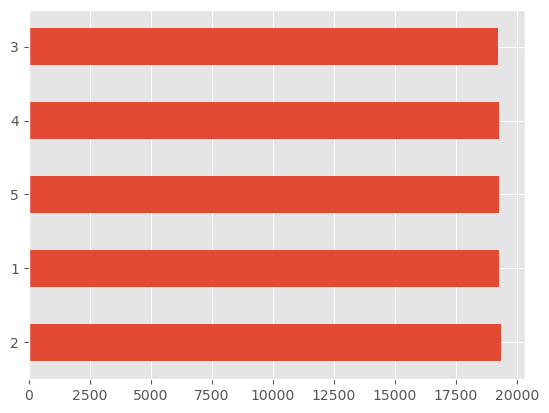

In [119]:
# Amount bins
AMOUNT = True
if AMOUNT:
      final['amount_cat'] = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5])
      
      final['amount_cat'].value_counts().plot(kind='barh')
      plt.show()
      
      qcut_series, qcut_intervals = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5],retbins=True)
      
      qcut_series.value_counts()

In [120]:
bins = [1,2,3,4,5]
for bin, interval in zip(bins, qcut_intervals):
    print(bin, round(interval,2))

1 0.01
2 21.74
3 85.0
4 216.0
5 550.57


In [121]:
if AMOUNT:
    final[['Amount', 'amount_cat']].head(10)

In [122]:
if AMOUNT:
    final['amount_cat'] = final['amount_cat'].astype(str)

In [124]:
# Foreign zipcode
zip_state = pd.read_csv('zip_code_database.csv')[['zip','state']]
zip_state.sample(5)
# Check if the zipcode of merchant is in the US
zip_state = pd.read_csv('zip_code_database.csv')['zip'].astype(float).astype(str).values
zip_state

array(['501.0', '544.0', '601.0', ..., '99928.0', '99929.0', '99950.0'],
      dtype=object)

In [125]:
mapping = list(map(lambda x: x not in zip_state, final['Merch zip']))
final = pd.concat([final, pd.DataFrame({'foreign': mapping})], axis = 1)

In [126]:
final.fillna(0,inplace=True)

In [127]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Merchnum_desc_State_count_0_by_7_sq,Merchnum_desc_State_count_0_by_14_sq,Merchnum_desc_State_count_0_by_30_sq,Merchnum_desc_State_count_0_by_60_sq,Merchnum_desc_State_count_1_by_7_sq,Merchnum_desc_State_count_1_by_14_sq,Merchnum_desc_State_count_1_by_30_sq,Merchnum_desc_State_count_1_by_60_sq,amount_cat,foreign
0,1,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118.0,P,3.62,0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,False
1,2,5142183973,2010-01-01,61003026333,SERVICEMERCHANDISE#81,MA,1803.0,P,31.42,0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,2,False
2,3,5142131721,2010-01-01,4503082993600,OFFICEDEPOT#191,MD,20706.0,P,178.49,0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,3,False
3,4,5142148452,2010-01-01,5509006296254,FEDEXSHP12/28/09AB#,TN,38118.0,P,3.62,0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,False
4,5,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118.0,P,3.62,0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,False


In [128]:
final.shape

(96397, 4250)

### Remove any redundant columns

In [129]:
final.set_index('Recnum', inplace = True)

In [130]:
%%time
# if the kernel dies in this cell it's likely due to memory problems.
# In that case, just write out the data file as is and you can read it in another notebook that just does deduping
print(final.shape)
final = final.T.drop_duplicates().T
final.shape

(96397, 4249)
CPU times: user 2min 58s, sys: 1min 42s, total: 4min 41s
Wall time: 5min 23s


(96397, 3139)

In [131]:
final.columns.values.tolist()

['Cardnum',
 'Date',
 'Merchnum',
 'Merch description',
 'Merch state',
 'Merch zip',
 'Transtype',
 'Amount',
 'Fraud',
 'Dow',
 'Dow_Risk',
 'state_risk',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'zip3',
 'card_zip3',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Cardnum_day_since',
 'Cardnum_count_0',
 'Cardnum_avg_0',
 'Cardnum_max_0',
 'Cardnum_med_0',
 'Cardnum_total_0',
 'Cardnum_actual/avg_0',
 'Cardnum_actual/max_0',
 'Cardnum_actual/med_0',
 'Cardnum_actual/toal_0',
 'Cardnum_count_1',
 'Cardnum_avg_1',
 'Cardnum_max_1',
 'Cardnum_med_1',
 'Cardnum_total_1',
 'Cardnum_actual/avg_1',
 'Cardnum_actual/max_1',
 'Cardnum_actual/med_1',
 'Cardnum_actual/toal_1',
 'Cardnum_count_3',
 'Cardnum_avg_3',
 'Cardnum_max_3',
 'Cardnum_med_3',
 'Cardnum_total_3',
 'Cardnum_actual/avg_3',
 'Cardnum_actual/max_3',


In [132]:
# careful about this line. Modify it so you only keep the variables (including the record # and dependent variable)
final_vars = final.iloc[:, np.r_[8, 10, 11, len(entities)+10:len(final.columns)]]

In [133]:
final_vars.head()

,Fraud,Dow_Risk,state_risk,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_actual/avg_0,...,Merchnum_desc_State_count_0_by_7_sq,Merchnum_desc_State_count_0_by_14_sq,Merchnum_desc_State_count_0_by_30_sq,Merchnum_desc_State_count_0_by_60_sq,Merchnum_desc_State_count_1_by_7_sq,Merchnum_desc_State_count_1_by_14_sq,Merchnum_desc_State_count_1_by_30_sq,Merchnum_desc_State_count_1_by_60_sq,amount_cat,foreign
Recnum,,,,,,,,,,,,,,,,,,,,,
1,0,0.025994,0.00797,1461.0,1,3.62,3.62,3.62,3.62,1.0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,False
2,0,0.025994,0.003304,1461.0,1,31.42,31.42,31.42,31.42,1.0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,2,False
3,0,0.025994,0.017282,1461.0,1,178.49,178.49,178.49,178.49,1.0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,3,False
4,0,0.025994,0.00797,1461.0,1,3.62,3.62,3.62,3.62,1.0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,False
5,0,0.025994,0.00797,0.0,2,3.62,3.62,3.62,7.24,1.0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,False


In [134]:
final_vars.shape

(96397, 3113)

In [135]:
final_vars.to_csv('candidate_variables.csv')

In [136]:
print('Duration: ', pd.datetime.now() - start_time)

Duration:  2:32:58.736733
